In [173]:
!pip install --quiet -U gensim

In [174]:
!pip install --quiet transformers

In [175]:
!pip3 install --quiet keras

In [176]:
!pip3 install --quiet keras

In [177]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
%cd drive/MyDrive/AML/HW4/classifier

[Errno 2] No such file or directory: 'drive/MyDrive/AML/HW4/classifier'
/content/drive/MyDrive/AML/HW4/classifier


In [179]:
!ls

BERT-pretrained-features.ipynb	       pre-trained-BERT-features-2.ipynb
classification_test_results.tsv        results
dreaddit			       test_data.tsv
dreaddit-test.csv		       tfi-df-embeddings.ipynb
dreaddit-train.csv		       train_data_for_students.tsv
dreddit.ipynb			       trump_tweets_classifiers.ipynb
GoogleNews-vectors-negative300.bin     w2v-domain-trained.ipynb
GoogleNews-vectors-negative300.bin.gz  w2v-google-news-pretrained.ipynb
logs


In [180]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import transformers
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available

# Visualization
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime
#Google Drive
from google.colab import drive

import re
import tqdm

import gensim, logging
from collections import defaultdict


In [181]:
tf_idf_stop_words = text.ENGLISH_STOP_WORDS

In [182]:
def set_seed(seed: int):
    # numpy
    np.random.seed(seed)

    # torch
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
         
set_seed(42)

In [183]:
def concat_two(original, new_x, features_from_original):
  new_df = pd.concat([new_x, original[features_from_original]], axis=1)
  return new_df

In [184]:
def get_domain(subreddit):
  if subreddit=='domesticviolence' or subreddit=='survivorsofabuse':
    return 'abuse';
  if subreddit=='anxiety' or subreddit=='stress':
    return 'anxiety';
  if subreddit=='almosthomeless' or subreddit=='assistance' or subreddit=='food_pantry' or subreddit=='homeless':
    return 'financial';
  if subreddit=='ptsd':
    return 'ptsd';
  else:
    return 'social';

In [185]:
df=pd.read_csv('dreaddit/dreaddit-train.csv')
df.shape

(2838, 116)

In [186]:
df_test = pd.read_csv('dreaddit/dreaddit-test.csv')
df_test.shape

(715, 116)

In [187]:
df['text_clean'] = df['text'].apply(lambda x: x.split())
df['domain'] = df['subreddit'].map(lambda x: get_domain(x))
X_train = df['text']
y_train = df['label']
y_train = y_train.to_list()
df.head(2)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_clean,domain
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,"[He, said, he, had, not, felt, that, way, befo...",ptsd
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,"[Hey, there, r/assistance,, Not, sure, if, thi...",financial


In [188]:
df_test['text_clean'] = df_test['text'].apply(lambda x: x.split())
df_test['domain'] = df_test['subreddit'].map(lambda x: get_domain(x))
X_test = df_test['text']
y_test = df_test['label']
y_test = y_test.to_list()
df_test.head(2)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_clean,domain
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000,"[Its, like, that,, if, you, want, or, not.“, M...",social
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909,"[I, man, the, front, desk, and, my, title, is,...",anxiety


In [189]:
ll = df[df.columns[1:]].corr().abs()['label'].sort_values(ascending = False)[:16].gt(0.2).drop('label')

In [220]:
top_correlations = list(ll.index)
top_correlations

['lex_liwc_Tone',
 'lex_liwc_Clout',
 'lex_liwc_i',
 'lex_liwc_negemo',
 'sentiment',
 'lex_dal_min_pleasantness',
 'lex_liwc_Authentic',
 'lex_liwc_posemo',
 'lex_liwc_anx',
 'lex_liwc_social',
 'lex_liwc_Analytic',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_anger',
 'lex_liwc_you']

In [221]:
vectorizer_tfidf = TfidfVectorizer(max_features=25000, ngram_range=(1,3))
txt_fitted = vectorizer_tfidf.fit(X_test)

In [222]:
tf_idf_map = dict(zip(txt_fitted.get_feature_names_out(), txt_fitted.idf_))
tf_idf_map =defaultdict(lambda:0.0, tf_idf_map)

In [223]:
final_train = []
for sentence in df['text_clean']:
  indexes = []
  tf_idfs = []
  for index, word in enumerate(sentence):
    row = np.zeros(500, dtype=float)
    indexes.append(index)
    tf_idfs.append(tf_idf_map[word])
  np.put(row, indexes, tf_idfs)
  final_train.append(row)
final_train = np.stack( final_train, axis=0 )
final_train.shape

(2838, 500)

In [224]:
final_test = []
for sentence in df_test['text_clean']:
  indexes = []
  tf_idfs = []
  for index, word in enumerate(sentence):
    row = np.zeros(500, dtype=float)
    indexes.append(index)
    tf_idfs.append(tf_idf_map[word])
  np.put(row, indexes, tf_idfs)
  final_test.append(row)
final_test = np.stack( final_test, axis=0 )
final_test.shape

(715, 500)

In [225]:
ff = top_correlations
len(ff)

15

In [226]:
X = pd.DataFrame(final_train)
print(f'X.shape = {X.shape}')
test_X = pd.DataFrame(final_test)
print(f'test_X.shape = {test_X.shape}')

X = concat_two(df, X, ff)
print(f'features - X.shape = {X.shape}')
test_X = concat_two(df_test, test_X, ff)
print(f'features - test_X.shape = {test_X.shape}')

# le_train = LabelEncoder()
# X = X.assign(subreddit = le_train.fit_transform(df['subreddit']))
# print(f'features + subreddit - X.shape = {X.shape}')

# le_test = LabelEncoder()
# test_X = test_X.assign(subreddit = le_test.fit_transform(df_test['subreddit']))
# print(f'features + subreddit - test_X.shape = {test_X.shape}')

X.shape = (2838, 500)
test_X.shape = (715, 500)
features - X.shape = (2838, 515)
features - test_X.shape = (715, 515)


In [227]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [228]:
def get_models():
    
    models = dict()
    models['lr'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga', C = 70.0))
    models['svm'] = make_pipeline(StandardScaler(),SVC())
    models['xgboost'] = XGBClassifier(n_estimators = 11, max_depth = 1)
    models['GBM'] = GradientBoostingClassifier(n_estimators = 10)
    models['adaboost'] = AdaBoostClassifier(n_estimators= 12)
    
    return models

In [229]:
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

>lr 0.76 (0.03)
>svm 0.76 (0.03)
>xgboost 0.74 (0.02)
>GBM 0.75 (0.03)
>adaboost 0.75 (0.03)


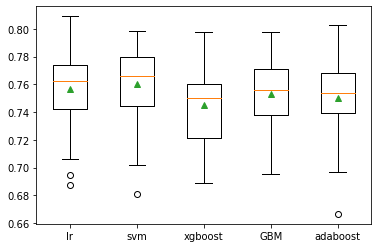

In [230]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.2f (%.2f)' % (name, scores.mean(), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [231]:
from sklearn.model_selection import GridSearchCV


classifier_lr = LogisticRegression()
model_lr = Pipeline([("classifier", classifier_lr)])


param_grid = [
    {'classifier__C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 70.0, 1e2, 1e5]},
    {'classifier__penalty' : ['l2']},
    {'classifier__solver'  : ['newton-cg', 'saga', 'lbfgs', 'liblinear']}
]

# Create grid search object

clf = GridSearchCV(model_lr, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1)

# Fit on data

model_lr = clf.fit(X.to_numpy(), y_train)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


In [232]:
print(print(clf.best_estimator_))

Pipeline(steps=[('classifier', LogisticRegression(C=0.001))])
None


In [233]:
predicted_train_lr = model_lr.predict(X.to_numpy())
accuracy_train_lr = accuracy_score(y_train, predicted_train_lr)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_lr))

predicted_test_lr = model_lr.predict(test_X.to_numpy())
accuracy_test_lr = accuracy_score(y_test, predicted_test_lr)
print('Accuracy Test data: {:.1%}'.format(accuracy_test_lr))

Accuracy Training data: 75.5%
Accuracy Test data: 74.1%


In [234]:
print(classification_report(y_test, predicted_test_lr))

              precision    recall  f1-score   support

           0       0.76      0.67      0.72       346
           1       0.72      0.80      0.76       369

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715

